# 0. Imports and setup

In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm.notebook import tqdm
from datetime import datetime
import scipy.stats


from PIL import Image
import glob

# MATLAB (Octave) setup
# Add m functions to the path

from oct2py import octave
octave.addpath('../MMA_SurrOpt_2023/')
octave.warning('off', 'Octave:possible-matlab-short-circuit-operator');

# convert the .m file into a csv file


# Template for running .m file
# octave.eval("""function [a, b] = toto(c);
#     a = c;
#     b = c + 1;
# end""")
# a,b = octave.eval("toto(3, nout =2)")
# a,b = octave.toto(3, nout = 2)
# print(a,b)


In [2]:
#Turn .mat to .csv
import scipy.io
mat = scipy.io.loadmat('data1209/1209log.mat')
print(mat['log'])
print(len(mat['log'][0]))
np.savetxt( "data1209/log1209.csv", mat['log'][0], delimiter=',')

[[8.83279632 7.56540165 8.01668332 ... 6.12575887 6.19414605 5.26265469]]
2187


## 0.1 Test torch 🔋

In [3]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.8082, 0.8931, 0.7562],
        [0.7639, 0.3285, 0.1469],
        [0.3118, 0.6063, 0.9362],
        [0.2636, 0.9318, 0.6157],
        [0.6933, 0.0502, 0.5931]])


## 1. Load data

In [4]:
# Initialize the container
design_vectors = [] # 
blfs = []

# path to the dataset (png files)
# path = 'E:\dev\Fall23Project\dataset/*.png'
# path_dummy = 'E:\dev\Fall23Project\dataset_dummy/*.png'
# path_buckling = "E:\dev\Fall23Project\dataset\Images/*.png"
# path_buckling = "data2000/Images/*.png"
# path_buckling_csv = "data2000/csvfiles/"
path_buckling = "data2000/Images/*.png"

# load buckling vector to the dataset.
blf_vector = genfromtxt("data1209/log1209.csv", delimiter=',')

#define new sizes
# new_size = (256,64)
new_size = (240,120)
x_size = []
y_size = []
for filename in glob.glob(path_buckling):
    # print(filename)
    # get idx, which is the filename without .png
    # idx = filename.split("\\")[-1].strip(".png")
    # print(filename)
    print(filename)
    idx = filename.split("\\")[-1].strip(".png")
    # print(idx)

    # idx = filename.split("\\")[-1].strip(".csv")
    # print(idx)
    my_data = genfromtxt("data2000/csvfiles/"+ idx+".csv", delimiter=',')
    im = Image.fromarray(my_data)

    # im=Image.open(path_buckling_csv+idx+".csv").convert('L')
    #Match the filename to the blf.
    blf_val = blf_vector[int(idx)-1]

    # image conversion to color
    # im=Image.open(filename).convert('L')

    if np.size(im) != new_size:
        # resize with the new_size
        print(np.size(im), " converted to ", new_size)
        x_size.append(np.size(im)[0])
        y_size.append(np.size(im)[1])
        im = im.resize(new_size, resample=0)
    
    # Normalize to be in between [0,1] and turn to array
    im_array = np.expand_dims(np.array(im).astype(np.float32), axis = 0)

    #Flatten the image to a 1D vector
    im_array_flatten = im_array.reshape(240*120)  # flatten x  shape[0] is the batch size, -1 is the last dimension of x

    #append the blf value into the 1D image vector.
    thisvector = np.append(im_array_flatten,blf_val)

    #append "this" design_vector into design_vectors
    design_vectors.append(thisvector)#


data2000/Images\1.png
data2000/Images\1000.png
data2000/Images\1001.png
data2000/Images\1002.png
data2000/Images\1012.png
data2000/Images\1013.png
data2000/Images\1014.png
data2000/Images\1015.png
data2000/Images\1016.png
data2000/Images\1017.png
data2000/Images\1024.png
data2000/Images\1025.png
data2000/Images\1026.png
data2000/Images\1027.png
data2000/Images\1028.png
data2000/Images\1029.png
data2000/Images\1039.png
data2000/Images\1040.png
data2000/Images\1041.png
data2000/Images\1042.png
data2000/Images\1043.png
data2000/Images\1044.png
data2000/Images\1051.png
data2000/Images\1052.png
data2000/Images\1053.png
data2000/Images\1054.png
data2000/Images\1055.png
data2000/Images\1056.png
data2000/Images\106.png
data2000/Images\1066.png
data2000/Images\1067.png
data2000/Images\1068.png
data2000/Images\1069.png
data2000/Images\107.png
data2000/Images\1070.png
data2000/Images\1071.png
data2000/Images\1078.png
data2000/Images\1079.png
data2000/Images\108.png
data2000/Images\1080.png
data20

Recheck out input

In [5]:
print("All input shapes")
design_vectors = np.array(design_vectors)

print(design_vectors.shape)

print("Each image shape")
print(design_vectors[0][:-1].reshape(new_size).shape)
print(max(design_vectors[0][:-1]))
print(np.mean(design_vectors[0][:-1]))

All input shapes
(942, 28801)
Each image shape
(240, 120)
1.0
0.2499979247708744


Visualize distribution of the input dataset

In [6]:
print(design_vectors[0].shape)
design_vectors[0,:-1].reshape(120,240).shape
print(design_vectors.shape)

(28801,)
(942, 28801)


Dataset:  8.642255932559088
Matlab:  8.642255931899054


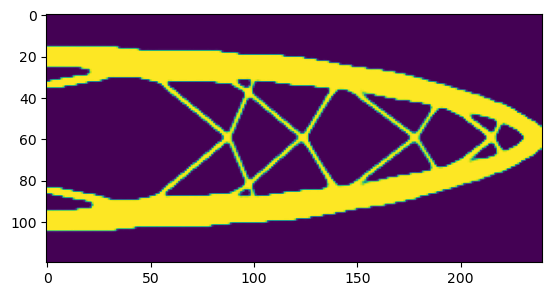

In [7]:
# print(design_vectors[0,:-1].reshape(120,240))
# design_vectors[design_vectors < 0.001] = 0
n = 1
plt.imshow(design_vectors[n,:-1].reshape(120,240))


np.savetxt("test_matlab.csv", design_vectors[n,:-1].reshape(120,240), delimiter=',')
calc_blf = octave.getblf("test_matlab", nout = 1)
# another_blf = octave.getblf("data2000/csvfiles/1")
print("Dataset: ", design_vectors[n,-1])
print("Matlab: ", calc_blf)
# print("Matlab but from csv ", another_blf)
# Matlab:  0.0026568316587896484

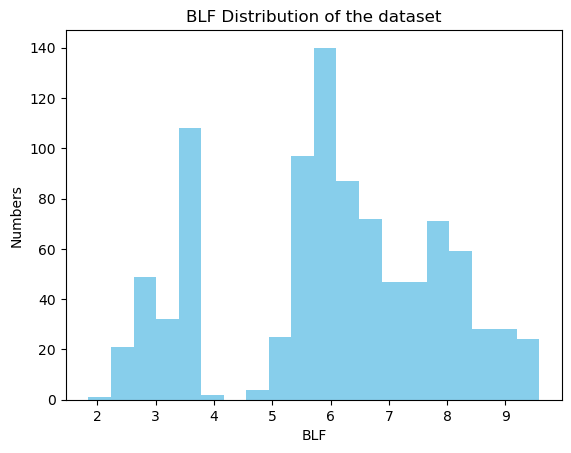

In [8]:
fig, ax = plt.subplots() 
plt.title('BLF Distribution of the dataset')
plt.hist(design_vectors[:,-1], bins = 20, color = 'skyblue')
ax.set_xlabel("BLF")
ax.set_ylabel("Numbers")
plt.savefig("Plots/BLF_distribution")
plt.show() 


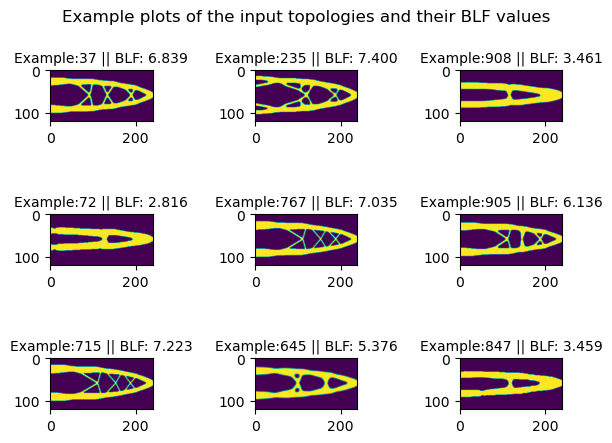

In [9]:
n = 3

fig = plt.figure()
plt.suptitle("Example plots of the input topologies and their BLF values")

plt.axis('off') 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=1, 
                    hspace=0.5)

np.random.seed(seed=1) #for reproducibility
count = 0
for i in range(1,n+1):
    for j in range(1,n+1):
        count +=1 
        fig.add_subplot(n, n, count) 

        idx = np.random.randint(0, len(design_vectors))
        plt.imshow(design_vectors[idx,:-1].reshape(120,240))
        plt.title("Example:"+ str(idx)+ " || BLF: {0:.3f}".format(design_vectors[idx,-1])) 
        a=plt.gca()
        a.title.set_size(10)

np.random.seed(seed=None)
plt.savefig("Plots/Example_Plots_of_inputs")


In [10]:
from torch.utils.data import DataLoader

batch_size = 64
print("\nTotal datapoints")
print(len(design_vectors))

# Training 70%, validating 30%
training_set = design_vectors[:int(len(design_vectors)*0.7)]
validating_set = design_vectors[int(len(design_vectors)*0.7)+1:]


print("\nTraining Set shape")
print(training_set.shape)
print("\nValidation Images")
print(validating_set.shape)

# turn into tensors -> compatibal format for Dataloader.
training_set = torch.Tensor(training_set)
training_set = np.array(training_set)
training_dataloader = DataLoader(training_set, shuffle= True, batch_size = batch_size) # create your dataloader

validating_set = torch.Tensor(validating_set)
validating_set = np.array(validating_set)
validating_dataloader = DataLoader(validating_set, shuffle= True, batch_size = batch_size) # create your dataloader



Total datapoints
942

Training Set shape
(659, 28801)

Validation Images
(282, 28801)


In [11]:
print(training_set)

[[4.2431377e-04 4.2698096e-04 4.2779715e-04 ... 1.6856407e-04
  1.6856407e-04 8.8327961e+00]
 [3.8233021e-04 4.2577423e-04 3.8755368e-04 ... 3.8741529e-04
  3.8741526e-04 8.6422558e+00]
 [1.3607247e-04 1.4047316e-04 1.2954028e-04 ... 2.6484963e-06
  2.6484963e-06 8.2301035e+00]
 ...
 [1.1080302e-03 1.1080302e-03 1.1080302e-03 ... 1.1080302e-03
  1.1080302e-03 6.2957568e+00]
 [9.9094305e-04 9.9096529e-04 9.9100301e-04 ... 9.9095819e-04
  9.9095819e-04 6.3012781e+00]
 [8.0636243e-04 8.0631953e-04 8.0622418e-04 ... 8.0409565e-04
  8.0409559e-04 5.1231422e+00]]


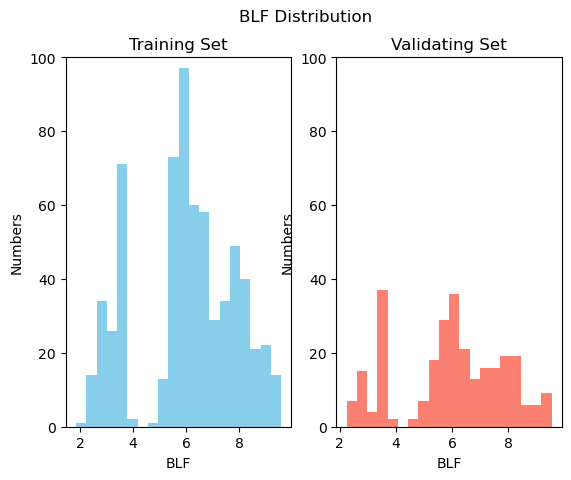

In [12]:
# histrogram of the distribution of the training and the validating sets
fig = plt.figure()
plt.suptitle("BLF Distribution")

fig.add_subplot(1, 2, 1) 
plt.title('Training Set')
plt.hist(training_set[:,-1], bins = 20, color = 'skyblue')
a=plt.gca()
a.set_xlabel("BLF")
a.set_ylabel("Numbers")
a.set_ylim([0, 100])

fig.add_subplot(1,2,2)
plt.title('Validating Set')
plt.hist(validating_set[:,-1], bins = 20, color = 'salmon')
a=plt.gca()
a.set_xlabel("BLF")
a.set_ylabel("Numbers")
a.set_ylim([0, 100])


plt.savefig("Plots/BLF_distribution_for_Training_Validating_sets")

## 2. Define VAE



In [13]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        # can use other losses too, MAE, etc.
        self.loss = torch.nn.MSELoss() 

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def reconstruction_loss(self, input_image, target_image):
        return self.loss(input_image, target_image) 
    

Encoder Part

In [14]:
class Encoder(torch.nn.Module):
  #we are dealing with images -> use convolutional network.
    def __init__(self, latent_dimensionality=2):
        super(Encoder, self).__init__()
        input_size_flatten = (120*240 + 1)

        self.fc_1 = torch.nn.Linear(in_features= input_size_flatten, out_features=1000)
        self.fc_2 = torch.nn.Linear(in_features= 1000, out_features=100)
        #add blf to it, so the size become 100 + 1 
        self.fc_3 = torch.nn.Linear(in_features= 100 + 1 , out_features=latent_dimensionality)
    
    def forward(self, x):
        #pull blf values out (for skip connection)
        blf = torch.unsqueeze(x[...,-1],1)

        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)

        #We add blf again here
        x = torch.cat([x,blf], dim=-1)
        x = self.fc_3(x)
        return x
    
# the decoder essentially mirrors the architecture of the encoder
class Decoder(torch.nn.Module):
    def __init__(self, latent_dimensionality=2):
        super(Decoder, self).__init__()

        self.fc_1 = torch.nn.Linear(in_features=latent_dimensionality, out_features=100)
        self.fc_2 = torch.nn.Linear(in_features=100, out_features = 1000)
        self.fc_3 = torch.nn.Linear(in_features=1000, out_features = 120*240 + 1)

    
    def forward(self, x):
        
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
      
        x1 = torch.sigmoid(x[...,:-1])  # squeeze pixel value between 0 and 1
        x2 = torch.unsqueeze(x[...,-1],1)

        x = torch.cat([x1,x2], dim =-1)
        return x

In [15]:
class VariationalAutoEncoder(AutoEncoder):
    def __init__(self, encoder, decoder, latent_dimensionality):
        super(VariationalAutoEncoder, self).__init__(encoder, decoder)

        self.latent_dimensionality = latent_dimensionality

    def forward(self, x):
        x = self.encoder(x)

        mu = x[:, : self.latent_dimensionality]
        log_variance = x[:, self.latent_dimensionality :]
        # sample from gaussian dis
        # project to log sigma^2 so we dont get negative values.
        variance = torch.exp(log_variance)
        eps = torch.randn_like(variance) #sample from a normal distribution
        sample = mu + torch.sqrt(variance) * eps #randomly scale, close to mu but not mu.
        x = self.decoder(sample)
        return x, mu, log_variance 

    def kullback_leibler_divergence(self, mu, log_variance):
        return 0.5 * torch.mean(mu ** 2 + torch.exp(log_variance) - (1 + log_variance))

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
vae_model = VariationalAutoEncoder(
    Encoder(latent_dimensionality= 4),
    Decoder(latent_dimensionality= 2),
    latent_dimensionality= 2,
).to(device)

In [18]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

(tensor([[ 0.4423,  0.4320,  0.4910,  ...,  0.4507,  0.4995, -0.1580],
        [ 0.4848,  0.4472,  0.4884,  ...,  0.4793,  0.5181, -0.1197],
        [ 0.4916,  0.4392,  0.4891,  ...,  0.4837,  0.5108, -0.0073],
        ...,
        [ 0.4882,  0.4511,  0.4901,  ...,  0.4923,  0.5103, -0.0430],
        [ 0.5186,  0.4517,  0.4803,  ...,  0.4877,  0.5218, -0.1520],
        [ 0.4789,  0.4722,  0.4721,  ...,  0.4447,  0.5097, -0.0055]],
       device='cuda:0', grad_fn=<CatBackward0>), tensor([[ 0.0590,  0.0941],
        [ 0.0378,  0.0919],
        [ 0.0509,  0.0894],
        [ 0.1070,  0.0533],
        [ 0.0670,  0.0931],
        [ 0.0789,  0.0613],
        [-0.0124,  0.0942],
        [ 0.0643,  0.0856],
        [ 0.0863,  0.0596],
        [ 0.0706,  0.0928],
        [ 0.0363,  0.0943],
        [ 0.0358,  0.0679],
        [ 0.0656,  0.0509],
        [ 0.0326,  0.0874],
        [ 0.1050,  0.0869],
        [ 0.0157,  0.0875],
        [ 0.0323,  0.1145],
        [ 0.0601,  0.1162],
        [ 0.

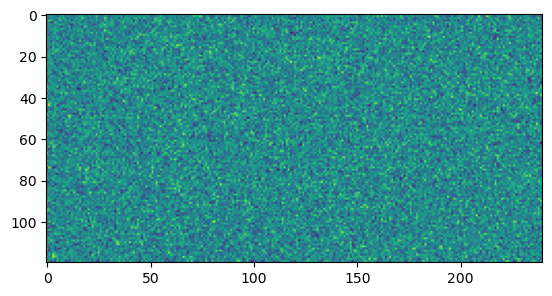

In [19]:
input_tensor = torch.rand(64, 120*240 + 1).to(device)

# Call the autoencoder
output = vae_model(input_tensor)
print(output)
# print(output.size())
imgplot = plt.imshow(output[0][0,:-1].reshape(120,240).detach().cpu().numpy())

In [20]:
training_losses = []
validating_losses = []

In [21]:
n_epochs = 200
reporting_frequency = 200

for i in tqdm(range(1, n_epochs + 1)):

    # training
    for j, (vector_input) in enumerate(training_dataloader):
        optimizer.zero_grad()
        vector_input = vector_input.to(device)
        reconstructed, mu, log_variance = vae_model(vector_input)
        reconstruction_loss = vae_model.reconstruction_loss(reconstructed, vector_input)
        # print(reconstruction_loss)
        kl_divergence_loss = vae_model.kullback_leibler_divergence(mu, log_variance)
        # print(kl_divergence_loss)
        #loss has 2 terms -> reconstruction loss and kl_divergence_loss
        #scale 0.01 so it't not too big/small so it includes the kl_divergence, but not too much that interrupt the workflow.
        loss = reconstruction_loss + 0.01 * kl_divergence_loss
        # print(loss)

        loss.backward()
        optimizer.step()
        # print(loss)
        training_losses.append(loss.detach().cpu().numpy())
        if (j + 1) % reporting_frequency == 0:
            print(
                "Epoch {0} | Mean training loss after {1} batches: {2:.3f}".format(
                    i, j + 1, np.mean(training_losses)
                )
            )

    # validating
    for j, (vector_input) in enumerate(validating_dataloader):
        vector_input = vector_input.to(device)
        reconstructed, _, _ = vae_model(vector_input)
        loss = vae_model.reconstruction_loss(reconstructed, vector_input)
        # print(loss)
        validating_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training total loss: {1:.3f} | Mean validating reconstruction loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validating_losses)
        )
    )

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 | Mean training total loss: 0.207 | Mean validating reconstruction loss: 0.095
Epoch 2 | Mean training total loss: 0.150 | Mean validating reconstruction loss: 0.088
Epoch 3 | Mean training total loss: 0.124 | Mean validating reconstruction loss: 0.074
Epoch 4 | Mean training total loss: 0.107 | Mean validating reconstruction loss: 0.065
Epoch 5 | Mean training total loss: 0.096 | Mean validating reconstruction loss: 0.060
Epoch 6 | Mean training total loss: 0.088 | Mean validating reconstruction loss: 0.056
Epoch 7 | Mean training total loss: 0.082 | Mean validating reconstruction loss: 0.053
Epoch 8 | Mean training total loss: 0.077 | Mean validating reconstruction loss: 0.050
Epoch 9 | Mean training total loss: 0.074 | Mean validating reconstruction loss: 0.048
Epoch 10 | Mean training total loss: 0.071 | Mean validating reconstruction loss: 0.047
Epoch 11 | Mean training total loss: 0.068 | Mean validating reconstruction loss: 0.046
Epoch 12 | Mean training total loss: 0.06

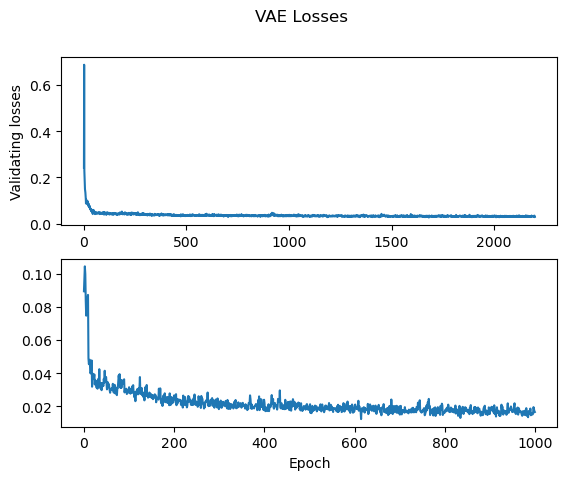

In [22]:
#plot losses
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('VAE Losses')

ax1.set_ylabel('Training losses')
p1 = ax1.plot(training_losses)

ax2.set_xlabel("Epoch")
ax1.set_ylabel('Validating losses')
p2 = ax2.plot(validating_losses)

plt.show

plt.savefig("Plots/VAE_losses")



In [23]:
vae_model.eval() #put this to inference mode.

VariationalAutoEncoder(
  (encoder): Encoder(
    (fc_1): Linear(in_features=28801, out_features=1000, bias=True)
    (fc_2): Linear(in_features=1000, out_features=100, bias=True)
    (fc_3): Linear(in_features=101, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=100, bias=True)
    (fc_2): Linear(in_features=100, out_features=1000, bias=True)
    (fc_3): Linear(in_features=1000, out_features=28801, bias=True)
  )
  (loss): MSELoss()
)

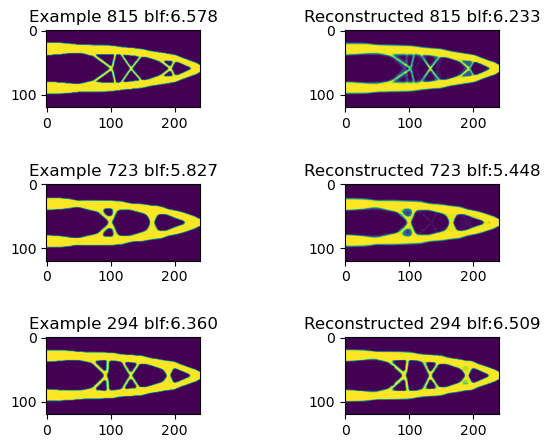

In [24]:
n = 3

fig = plt.figure()
plt.axis('off') 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

np.random.seed(seed=1234) #for reproducibility
for i in range(1,n+1):
    fig.add_subplot(n, 2, 2*i-1) 
    idx = np.random.randint(0, len(design_vectors))

    
    design_vector = design_vectors[idx,:]
    image_vector = design_vector[:-1]
    blf_val = design_vector[-1]

    plt.imshow(image_vector.reshape(120,240))
    # plt.title("Example:"+ str(idx) + " blf:" +str(blf_val)) 
    plt.title("Example {0} blf:{1:.3f}".format(idx, blf_val)) 
    fig.add_subplot(n, 2, 2*i) 

    reconstructed_vector,_,_ = vae_model(torch.tensor(design_vector.astype(np.float32)).to(device).unsqueeze(0))
    # print(len(reconstructed_vector))
    # print(reconstructed_vector)
    reconstructed_image = reconstructed_vector[0,:-1].detach().reshape(120,240).cpu()
    reconstructed_blf = reconstructed_vector[0,-1].detach().cpu().numpy()


    plt.imshow(reconstructed_image)
    #  "Epoch {0} | Mean training loss: {1:.3f} | Mean validating loss: {2:.3f}".format(
    #         i, np.mean(training_losses), np.mean(validating_losses)
    #     )
    plt.title("Reconstructed {0} blf:{1:.3f}".format(idx, reconstructed_blf)) 


np.random.seed(seed=None)

plt.savefig("Plots/Reconsturcted_topology")

# Check Predicted vs Actual BLF values

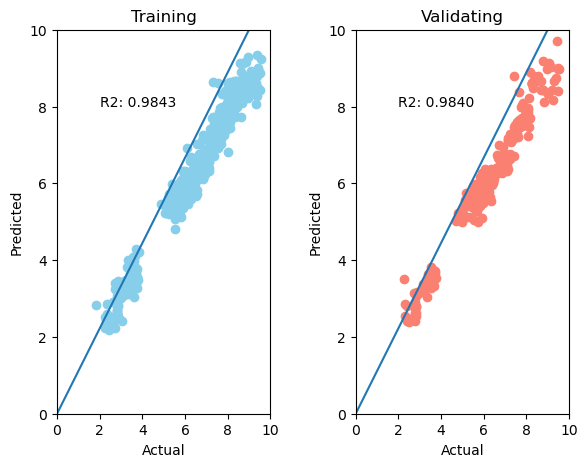

In [25]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.title("Training")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)
a = plt.gca()
a.set_xlabel("Actual")
a.set_ylabel('Predicted')
a.set_xlim([0, 10])
a.set_ylim([0, 10])
plt.plot(np.linspace(0,10,10))

training_reconstructed_blf_array = []
for i in range(len(training_set)):
# for i in range(1):    
    design_vector = training_set[i,:]

    image_vector = design_vector[:-1]
    blf_val = design_vector[-1]

    reconstructed_vector, mu, log_variance= vae_model(torch.tensor(design_vector.astype(np.float32)).to(device).unsqueeze(0))

    reconstructed_blf = reconstructed_vector[0,-1].detach().cpu().numpy()
    plt.scatter(blf_val, reconstructed_blf, c = 'skyblue')
    training_reconstructed_blf_array.append(reconstructed_blf)

slope, intercept, r_value1, p_value, std_err = scipy.stats.linregress(training_set[:,-1], training_reconstructed_blf_array)
plt.text(2,8, "R2: {x:.4f}".format(x = r_value1))

fig.add_subplot(1,2,2)
plt.plot(np.linspace(0,10,10))
plt.title("Validating")
a = plt.gca()
a.set_xlabel("Actual")
a.set_ylabel('Predicted')
a.set_xlim([0, 10])
a.set_ylim([0, 10])
###########################################
validating_reconstructed_blf_array = []
for i in range(len(validating_set)):
# for i in range(1):    
    design_vector = validating_set[i,:]

    image_vector = design_vector[:-1]
    blf_val = design_vector[-1]

    reconstructed_vector, mu, log_variance= vae_model(torch.tensor(design_vector.astype(np.float32)).to(device).unsqueeze(0))

    reconstructed_blf = reconstructed_vector[0,-1].detach().cpu().numpy()
    plt.scatter(blf_val, reconstructed_blf, c = 'salmon')
    validating_reconstructed_blf_array.append(reconstructed_blf)

slope, intercept, r_value2, p_value, std_err = scipy.stats.linregress(validating_set[:,-1], validating_reconstructed_blf_array)
plt.text(2,8, "R2: {x:.4f}".format(x = r_value2))

plt.savefig("Plots/Predict_vs_Actual_plot")

Get all of the encodings + plot them into a space

In [26]:
def get_all_encodings(model, dataloader):
    all_encoded = []
    all_blf = []
    for _ , input_vector in enumerate(dataloader):
        encoding = model.encoder(input_vector.to(device)).detach().cpu().numpy()
        all_encoded.append(encoding)
        # print(input_vector.shape)
        all_blf.append(input_vector[:,-1])
        #all_labels.append(labels.numpy())

    all_encoded = np.concatenate(all_encoded)
    all_blf = np.concatenate(all_blf)

    return all_encoded , all_blf


def plot_topopt_encoding(model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Training data
    ax[0].set_title(label="Encoding of Topology training set")
    all_encoded_train, all_blf_train = get_all_encodings(model, training_dataloader)
    training_bbox = np.min(all_encoded_train, axis=0), np.max(all_encoded_train, axis=0)

    scatter1 = ax[0].scatter(
        all_encoded_train[:, 0],
        all_encoded_train[:, 1],
        c=all_blf_train,
        alpha=0.2,
        cmap="plasma",
        label="Training",
    )
    # plt.colorbar(scatter1)

    # Validation data
    ax[1].set_title(label="Encoding of Topology validating set")
    all_encoded, all_blf = get_all_encodings(model, validating_dataloader)
    validating_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter2 = ax[1].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_blf,
        alpha=0.5,
        marker="+",
        cmap="plasma",
    )
    # plt.colorbar(scatter2)
    cbar = fig.colorbar(scatter2, ax=ax.ravel().tolist(), shrink=0.95)

    # ax[1].legend(*scatter.legend_elements(), title="blf", bbox_to_anchor=(1, 0.5))

    # adjust such that both subplots have same bounds
    ax[0].set_xlim(
        min(training_bbox[0][0], validating_bbox[0][0]),
        max(training_bbox[1][0], validating_bbox[1][0]),
    )
    ax[1].set_xlim(
        min(training_bbox[0][0], validating_bbox[0][0]),
        max(training_bbox[1][0], validating_bbox[1][0]),
    )

    ax[0].set_ylim(
        min(training_bbox[0][1], validating_bbox[0][1]),
        max(training_bbox[1][1], validating_bbox[1][1]),
    )
    ax[1].set_ylim(
        min(training_bbox[0][1], validating_bbox[0][1]),
        max(training_bbox[1][1], validating_bbox[1][1]),
    )


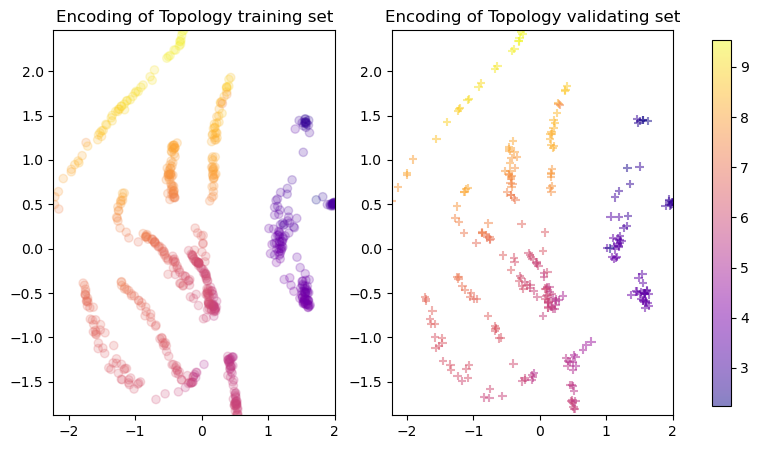

In [27]:
plot_topopt_encoding(vae_model)
plt.savefig("Plots/Encoding_plot")

For saving the weights to be used later.

In [28]:
saved_file_name = "vae1209_ver1.pth"  
torch.save(vae_model.state_dict(), saved_file_name)

# Load model parameters
reloaded_vae_model = VariationalAutoEncoder(
    Encoder(latent_dimensionality=4),
    Decoder(latent_dimensionality=2),
    latent_dimensionality=2).to(device)

reloaded_vae_model.load_state_dict(torch.load(saved_file_name))
reloaded_vae_model.eval()

VariationalAutoEncoder(
  (encoder): Encoder(
    (fc_1): Linear(in_features=28801, out_features=1000, bias=True)
    (fc_2): Linear(in_features=1000, out_features=100, bias=True)
    (fc_3): Linear(in_features=101, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=100, bias=True)
    (fc_2): Linear(in_features=100, out_features=1000, bias=True)
    (fc_3): Linear(in_features=1000, out_features=28801, bias=True)
  )
  (loss): MSELoss()
)

In [29]:
# plt.figure(figsize=(7, 7))

# n = 20  # sampling resolution
# # evenly-spaced grid sampling in latent space
# z = np.linspace(-3, 3, n)
# Z1, Z2 = np.meshgrid(z, z)
# Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# plt.scatter(Z[:, 0], Z[:, 1], s=50, c="black", label="Grid sampling")

# z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
# Z1, Z2 = np.meshgrid(z, z)
# Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# plt.scatter(Z[:, 0], Z[:, 1], marker="+", s=100, c="red", label="PPF sampling")
# plt.legend(fontsize=10, bbox_to_anchor=(1, 0.5))
# plt.show()

16
[[-2.5758293  -2.5758293 ]
 [-0.42614801 -2.5758293 ]
 [ 0.42614801 -2.5758293 ]
 [ 2.5758293  -2.5758293 ]
 [-2.5758293  -0.42614801]
 [-0.42614801 -0.42614801]
 [ 0.42614801 -0.42614801]
 [ 2.5758293  -0.42614801]
 [-2.5758293   0.42614801]
 [-0.42614801  0.42614801]
 [ 0.42614801  0.42614801]
 [ 2.5758293   0.42614801]
 [-2.5758293   2.5758293 ]
 [-0.42614801  2.5758293 ]
 [ 0.42614801  2.5758293 ]
 [ 2.5758293   2.5758293 ]]
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
[-2.5758293  -0.42614801  0.42614801  2.5758293  -2.5758293  -0.42614801
  0.42614801  2.5758293  -2.5758293  -0.42614801  0.42614801  2.5758293
 -2.5758293  -0.42614801  0.42614801  2.5758293 ]
[-2.5758293  -2.5758293  -2.5758293  -2.5758293  -0.42614801 -0.42614801
 -0.42614801 -0.42614801  0.42614801  0.42614801  0.42614801  0.42614801
  2.5758293   2.5758293   2.5758293   2.5758293 ]


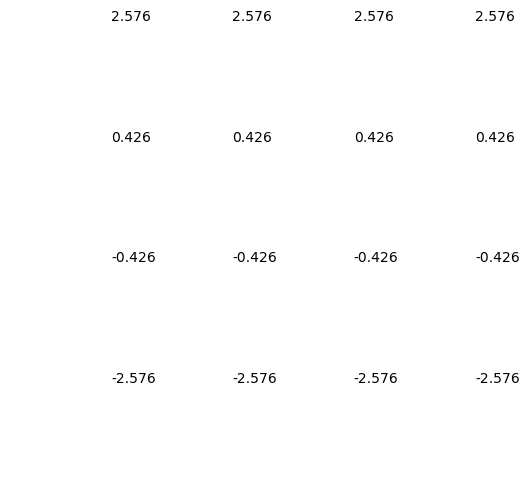

In [30]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
count = 0
z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, 4))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T
print(len(Z))
print(Z)
for k in range(0, 16):

    i, j = int(count / 4), int(count % 4)
    print(i,j)
    axes[4-1-i, j].text(1,1,"{0:.3f}".format(Z[count,1]))
    axes[i, j].axis("off")
    count +=1 
print(Z[:,0])
print(Z[:,1])

## 3. Post Processing

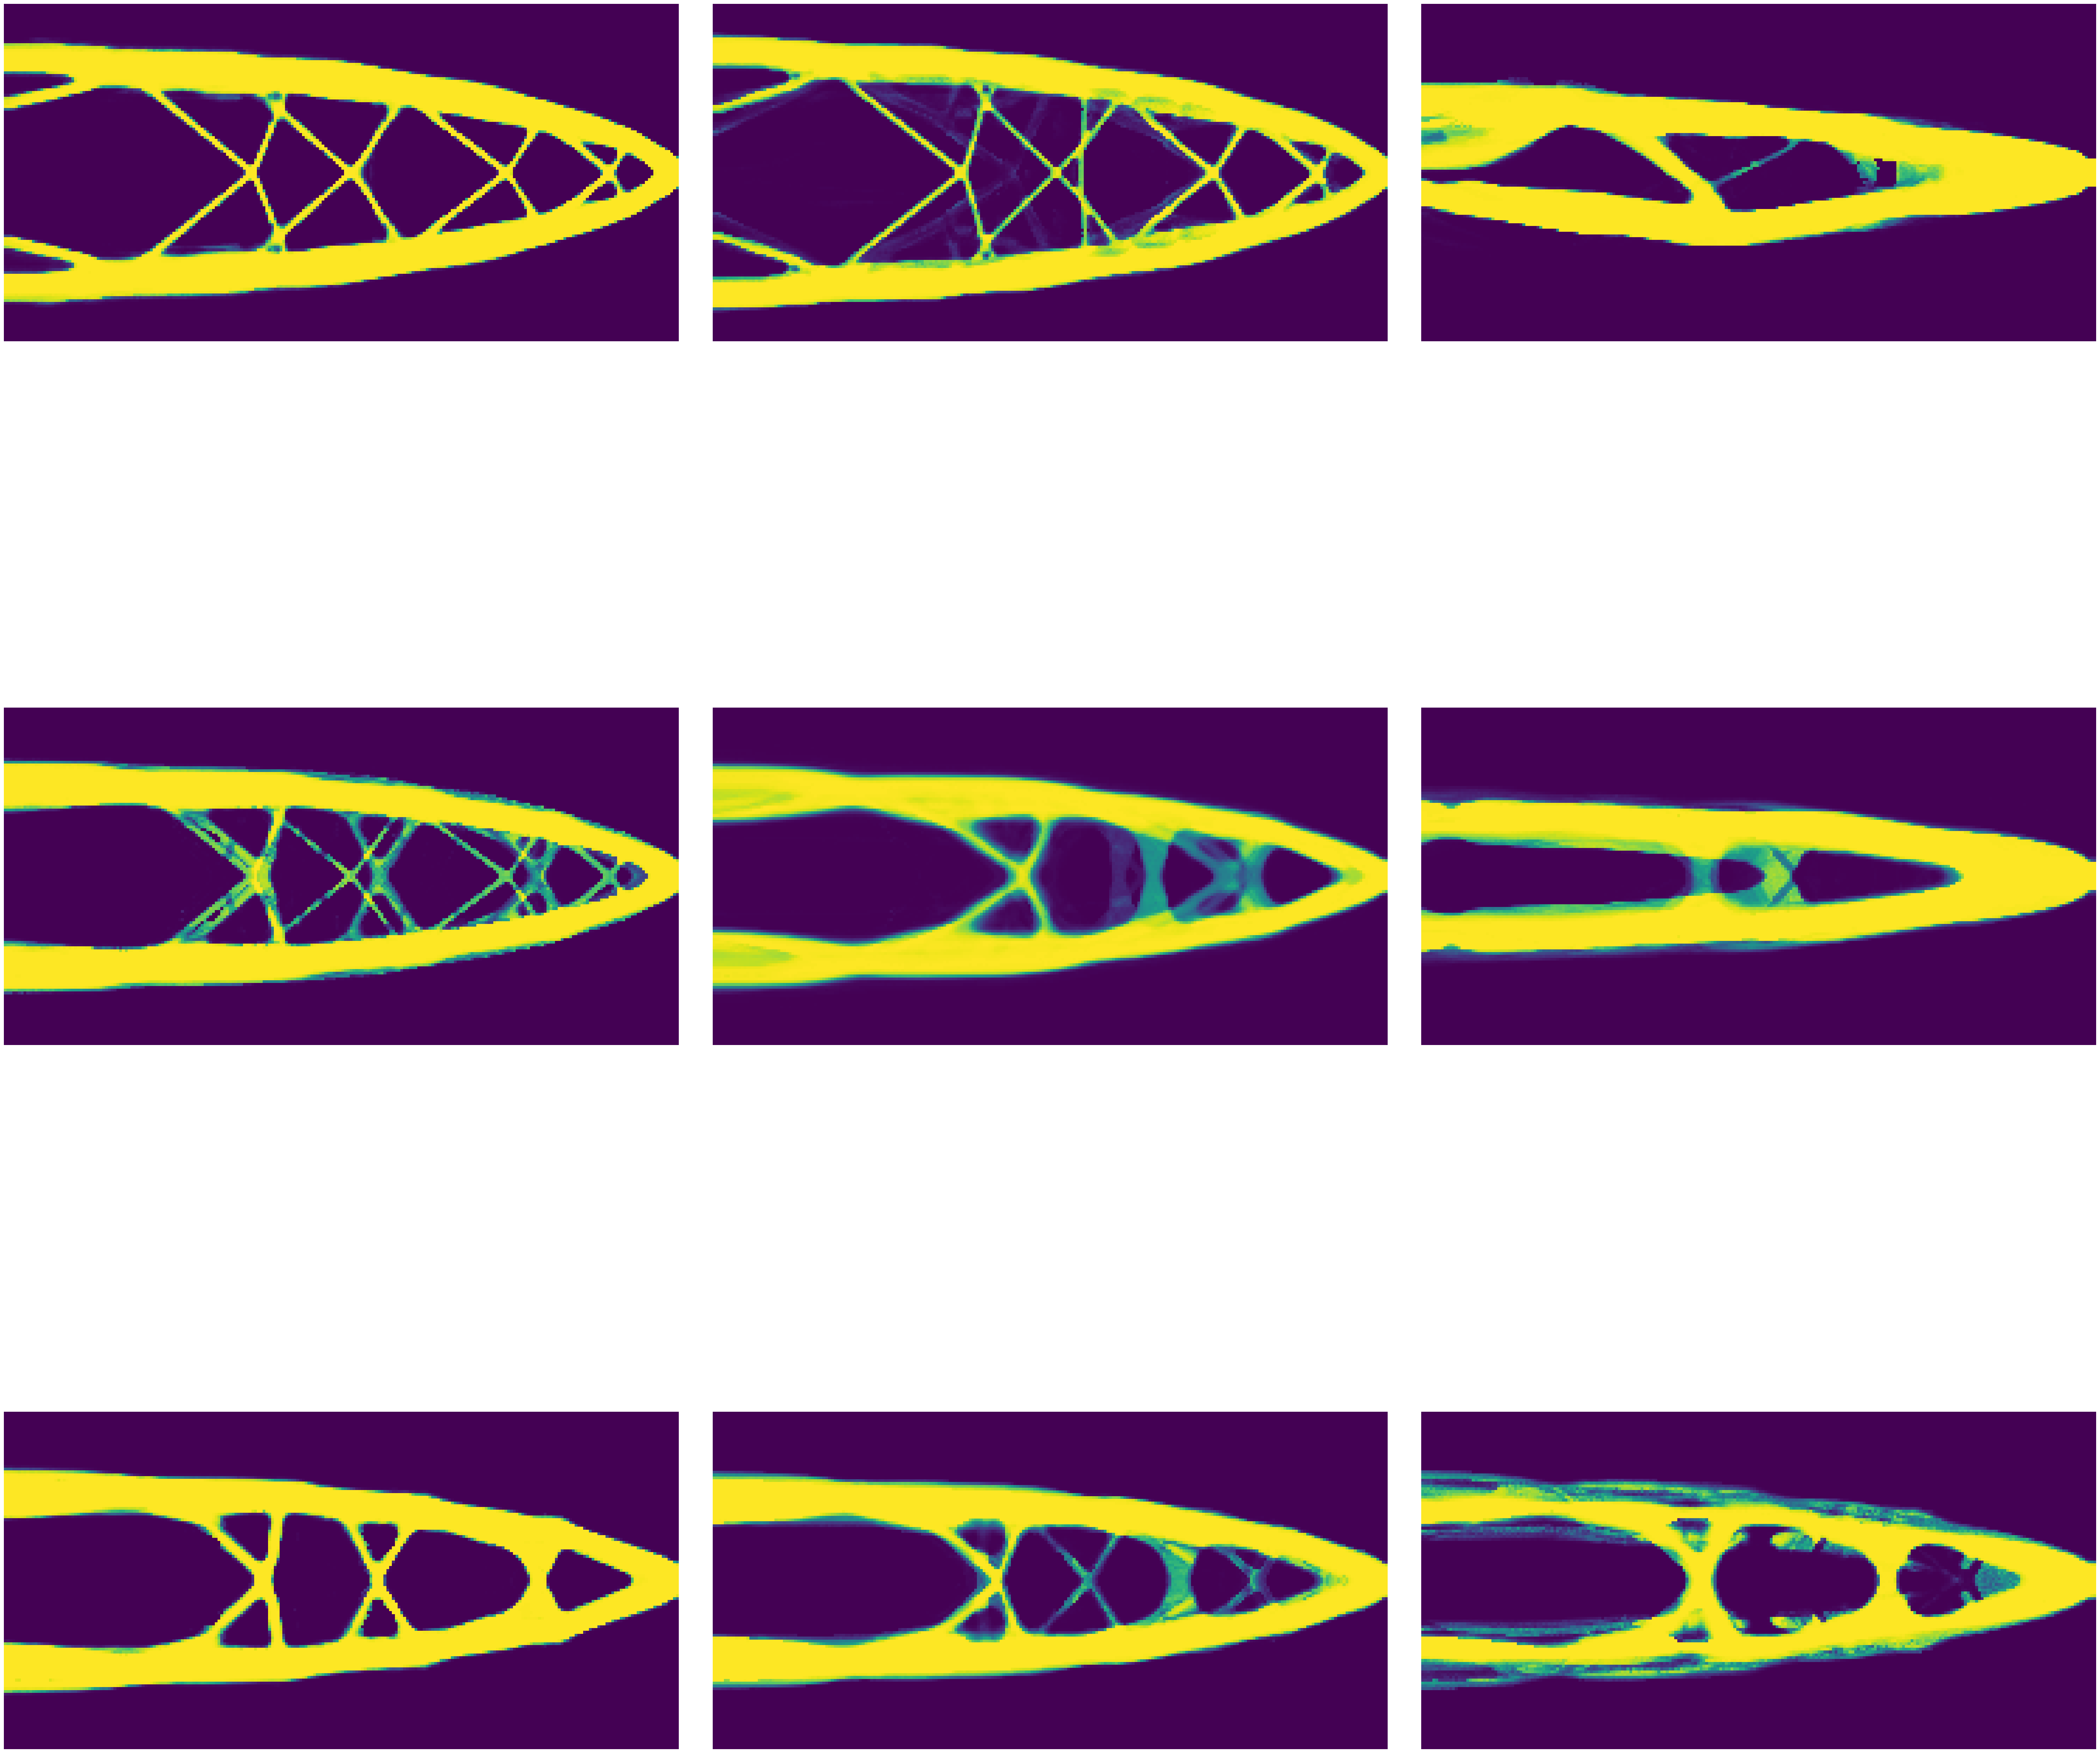

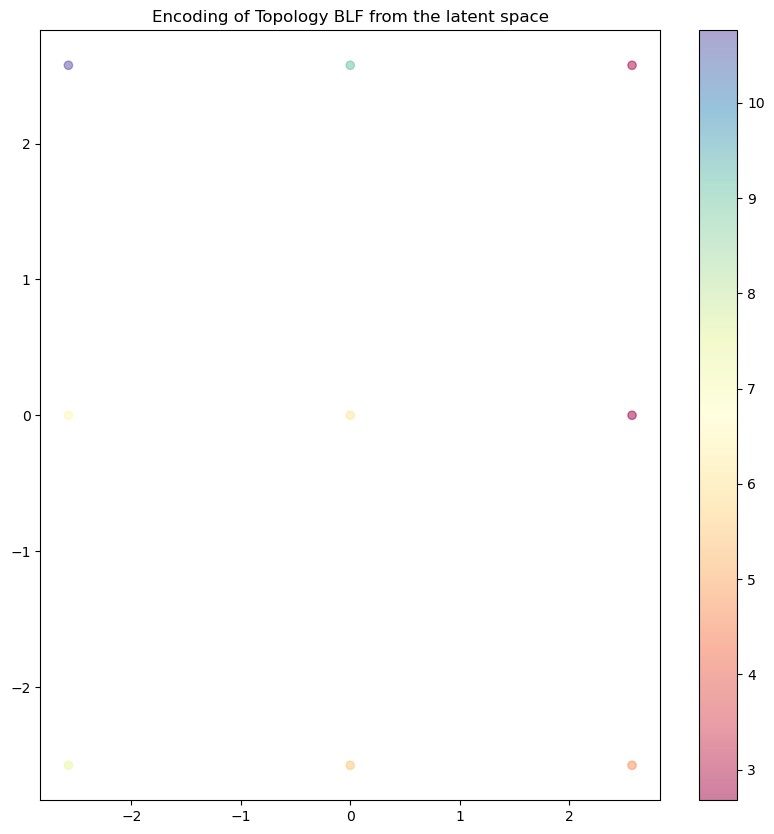

In [31]:
def plot_latent_space_no_matlab(n):

    # grid sampling in latent space
    z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
    Z1, Z2 = np.meshgrid(z, z)
    Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

    # decode samples
    ims = vae_model.decoder(torch.tensor(Z).float().to(device)).detach().cpu()

    fig, axes = plt.subplots(n, n, figsize=(70, 70))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    small_reconstructed_blf_array = ims[:,-1]
    count = 0
    for k in range(0, ims.shape[0]):
        i, j = int(count / n), int(count % n)
        # print(i,j)
        axes[n-1-i, j].imshow(ims[k,:-1].reshape(120,240))
        axes[i, j].axis("off")

        np.savetxt("savelog/csv/latent_sample_topology_n"+str(n)+"_"+str(i)+"_" + str(j)+".csv", ims[k,:-1].reshape(120,240), delimiter=',')
        count += 1
    plt.savefig("savelog/Plots_topology_GaussSpace")


    fig, ax = plt.subplots(figsize=(10, 10))

    # Training data
    ax.set_title(label="Encoding of Topology BLF from the latent space")

    training_bbox = np.min(Z, axis=0), np.max(Z, axis=0)

    scatter1 = ax.scatter(
        Z[:, 0],
        Z[:, 1],
        c= small_reconstructed_blf_array,
        alpha=0.5,
        cmap="Spectral",
        label="Latent Space",
    )
    plt.colorbar(scatter1)
    plt.show()
plot_latent_space_no_matlab(3)

A function to calculate the latent space along with BLF from MATLAB

In [32]:
def calc_latent_space(n):

    z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
    Z1, Z2 = np.meshgrid(z, z)
    Z = np.vstack([Z1.flatten(), Z2.flatten()]).T
    
    # decode samples
    ims = vae_model.decoder(torch.tensor(Z).float().to(device)).detach().cpu()

    # plot
    fig, axes = plt.subplots(n, n, figsize=(35, 35))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    structure_array = []
    blf_array_matlab = np.zeros((n,n))
    blf_array_reconstructed = np.zeros((n,n))
    count = 0

    for k in tqdm(range(0, ims.shape[0])):
        
        i, j = int(count / n), int(count % n)
        print("Number: " + str(k))
        print("(x,y) =("+str(i)+","+str(j)+")")
        ims_array = ims[k, :-1].reshape(120,240)
        axes[n-1-i, j].imshow(ims_array)
        axes[i, j].axis("off")

        structure_array.append(ims[k,:-1])
        reconstructed_blf = ims[k,-1]
        blf_array_reconstructed[i,j] = reconstructed_blf
        filename = "logMATLABoutput/batch_"+str(n)+"_"+ str(k)
        np.savetxt( filename +'.csv', ims_array, delimiter=',')
        blf_array_matlab[i,j] = octave.getblf(filename, nout = 1)
        print(blf_array_matlab[i,j])
        # print(i,j,blf_array[i,j])
        count += 1
    plt.savefig('savelog/plot_latent_topology'+str(n))
    plt.show()
    return blf_array_matlab, blf_array_reconstructed, structure_array





Functions to plot the blf from the calculated latent space

In [33]:
def plot_latent_space_blf(matlab_blf, my_blf, n = n):
    
    z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
    Z1, Z2 = np.meshgrid(z, z)
    Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Training data
    ax[0].set_title(label="Encoding of Topology BLF from the latent space")

    training_bbox = np.min(Z, axis=0), np.max(Z, axis=0)

    scatter1 = ax[0].scatter(
        Z[:, 0],
        Z[:, 1],
        c= my_blf,
        alpha=0.5,
        cmap="Spectral",
        label="Latent Space",
    )
    plt.colorbar(scatter1)

    # # MATLAB calc data.

    ax[1].set_title(label="Encoding of Topology BLF calc from Matlab")

    scatter2 = ax[1].scatter(
        Z[:, 0],
        Z[:, 1],
        c=matlab_blf,
        alpha=0.5,
        marker="+",
        cmap="Spectral",
    )
    plt.colorbar(scatter2)

    # ax[1].legend(*scatter.legend_elements(), title="blf", bbox_to_anchor=(1, 0.5))

    # adjust such that both subplots have same bounds
    ax[0].set_xlim(
        training_bbox[0][0]-0.5,
        training_bbox[1][0]+0.5,
    )

    ax[0].set_ylim(
        training_bbox[0][1]-0.5,
        training_bbox[1][1]+0.5
    )

    ax[1].set_xlim(
        training_bbox[0][0]-0.5,
        training_bbox[1][0]+0.5,
    )

    ax[1].set_ylim(
        training_bbox[0][1]-0.5,
        training_bbox[1][1]+0.5
    )

    return fig

def plot_normalized_latent_space_blf(matlab_blf, my_blf, n = n):
    
    z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
    Z1, Z2 = np.meshgrid(z, z)
    Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Training data
    ax[0].set_title(label="Encoding of Topology BLF from the latent space")

    training_bbox = np.min(Z, axis=0), np.max(Z, axis=0)

    scatter1 = ax[0].scatter(
        Z[:, 0],
        Z[:, 1],
        c= my_blf/np.max(my_blf),
        alpha=0.5,
        cmap="Spectral",
        label="Our Model",
    )
    plt.colorbar(scatter1)

    # # MATLAB calc data.

    ax[1].set_title(label="Encoding of Topology BLF calc from Matlab")

    scatter2 = ax[1].scatter(
        Z[:, 0],
        Z[:, 1],
        c=matlab_blf/np.max(matlab_blf),
        alpha=0.5,
        marker="+",
        cmap="Spectral",
        label = "MATLAB"
    )
    plt.colorbar(scatter2)

    # ax[1].legend(*scatter.legend_elements(), title="blf", bbox_to_anchor=(1, 0.5))

    # adjust such that both subplots have same bounds
    ax[0].set_xlim(
        training_bbox[0][0]-0.5,
        training_bbox[1][0]+0.5,
    )

    ax[0].set_ylim(
        training_bbox[0][1]-0.5,
        training_bbox[1][1]+0.5
    )

    ax[1].set_xlim(
        training_bbox[0][0]-0.5,
        training_bbox[1][0]+0.5,
    )

    ax[1].set_ylim(
        training_bbox[0][1]-0.5,
        training_bbox[1][1]+0.5
    )

    return fig

def plot_distribution(matlab_blf, my_blf):
    # histrogram of the distribution of the training and the validating sets
    fig = plt.figure()
    plt.suptitle("Reconstructed BLF Distribution")

    fig.add_subplot(1, 2, 1) 
    plt.title('Dataset')
    plt.hist(design_vectors[:,-1], bins = 20, color = 'skyblue')
    a=plt.gca()
    a.set_xlabel("BLF")
    a.set_ylabel("Numbers")
    a.set_ylim([0, 150])
    a.set_xlim([0, 12])

    fig.add_subplot(2,2,2)
    plt.title('Predicted Set') 
    plt.hist(my_blf.flatten(), bins = 20, color = 'steelblue', label = 'predicted', alpha = 0.5)
    a=plt.gca()
    a.set_xlim([0, 12])
    plt.xticks([])


    fig.add_subplot(2,2,4)
    plt.title('MATLAB Set')
    plt.hist(matlab_blf.flatten(), bins = 20, color = 'salmon', label = 'actual', alpha = 0.5)
    a=plt.gca()
    a.set_xlabel("BLF")
    a.set_ylabel("Numbers")
    # a.set_ylim([0, 500])
    a.set_xlim([0, 12])
    # a.legend()
    return fig
    


In [34]:
def plot_and_save(n):
    matlab_blf, my_blf, topologies = calc_latent_space(n)
    np.savetxt( 'savelog/csv/matlab_blf_' +str(n) +'.csv', matlab_blf, delimiter=',')
    np.savetxt( 'savelog/csv/my_blf_' +str(n) +'.csv', my_blf , delimiter=',')
    np.savetxt( 'savelog/csv/topologies_' +str(n) +'.csv', topologies , delimiter=',')

    fig_original = plot_latent_space_blf(matlab_blf, my_blf, n)
    plt.savefig('savelog/plot_original_'+str(n))
    fig_normalized = plot_normalized_latent_space_blf(matlab_blf, my_blf, n)
    plt.savefig('savelog/plot_normalized_'+str(n))

    plot_distribution(matlab_blf, my_blf)
    plt.savefig("savelog/plot_BLF_distribution_predicted_actual"+str(n))
    



In [35]:
plot_and_save(5)

  0%|          | 0/25 [00:00<?, ?it/s]

0
6.188849663833859
1
5.983625668718744
2
5.841264929174562
3
5.755677123873552
4
4.087937211445455
5
3.074384028885908
6
6.53844398402426
7
5.983599243906086
8
5.58271165907994
9
3.504183865953101
10
6.772107773303169
11
6.7702312475201145
12
6.343509084210015
13
4.409210856663279
14
3.067247597556393
15
7.921649109588433
16


## This block will take ~ a day, so...

In [ ]:
plot_and_save(5)
plot_and_save(10)
plot_and_save(20)
plot_and_save(30)
# plot_and_save(40)
# plot_and_save(50)



  0%|          | 0/100 [00:00<?, ?it/s]

0
It.: 1 g0: 1.0000 g1:2.62e-02 penalK:   1.00 penalG:   1.00 eta:   0.50 beta:    2.0 ch:1.000e+00 lm:5.046e+02
3.9437028035293857
1
It.: 1 g0: 1.0000 g1:4.76e-04 penalK:   1.00 penalG:   1.00 eta:   0.50 beta:    2.0 ch:1.000e+00 lm:2.892e+00
7.7562623629249305
2
It.: 1 g0: 1.0000 g1:1.65e-02 penalK:   1.00 penalG:   1.00 eta:   0.50 beta:    2.0 ch:1.000e+00 lm:2.599e+03
-7.600768628430886
3
It.: 1 g0: 1.0000 g1:1.88e-02 penalK:   1.00 penalG:   1.00 eta:   0.50 beta:    2.0 ch:1.000e+00 lm:2.939e+00
8.540434997480006
4
It.: 1 g0: 1.0000 g1:1.68e-02 penalK:   1.00 penalG:   1.00 eta:   0.50 beta:    2.0 ch:1.000e+00 lm:2.743e+00
8.703975157188726
5
It.: 1 g0: 1.0000 g1:1.78e-02 penalK:   1.00 penalG:   1.00 eta:   0.50 beta:    2.0 ch:1.000e+00 lm:2.692e+00
8.876581950821778
6
It.: 1 g0: 1.0000 g1:1.92e-02 penalK:   1.00 penalG:   1.00 eta:   0.50 beta:    2.0 ch:1.000e+00 lm:3.384e+00
9.044752151264335
7
It.: 1 g0: 1.0000 g1:2.36e-02 penalK:   1.00 penalG:   1.00 eta:   0.50 beta: 

Plot the 5 highest performance topologies

In [ ]:
#load the csv and blf
topologies = np.array(genfromtxt("savelog/csv/topologies_50.csv", delimiter=','))
blfs = np.array(genfromtxt("savelog/csv/my_blf_50.csv", delimiter=','))



(2500, 28800)
(50, 50)


In [ ]:
print(topologies.shape)
print(blfs.shape)

(2500, 28800)
(50, 50)


In [ ]:
idx = np.argmax(blfs)
print(idx)
top_blfs = np.array(blfs.flatten()[idx])
top_topologies = np.array(topologies[idx])

2499


In [ ]:
print(top_topologies.shape)

# print(top_topologies)
for i in top_topologies:
    print(i)

print(top_blfs)
np.savetxt( 'savelog/csv/top_topology.csv', top_topologies , delimiter=',')
    

(28800,)
7.602082405355759e-06
4.893876848655054e-06
4.108067969355034e-06
5.445512215374038e-06
3.952545284846565e-06
1.7255528064197279e-06
2.996749344674754e-06
2.183704054914415e-06
2.6444286049809307e-06
1.524296294519445e-06
5.473972578329267e-06
3.803051413342473e-06
1.0937622391793411e-05
6.1451178225979675e-06
3.9753444980306085e-06
3.1783677059138427e-06
1.0353812740504509e-06
4.083168278157245e-06
4.023769633931806e-06
3.2931584428297356e-06
3.0792316465522163e-06
1.8075413663609652e-06
2.984806997119449e-06
3.0140636226860806e-06
5.383051302487729e-06
2.9796819944749586e-06
2.3326304017246002e-06
1.5557142205580021e-06
6.82059908285737e-06
5.147936462890357e-06
8.837246809889621e-07
6.337227659969358e-06
6.6874017647933215e-06
7.9140017987811e-06
3.638066573330434e-06
4.890125183010241e-06
7.448429641954135e-06
1.5299600590878981e-06
2.959501216537319e-06
4.255543444742216e-06
5.123838946019532e-06
1.5686800907133147e-06
1.0117372767126653e-05
6.5879257817869075e-06
2.47657

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

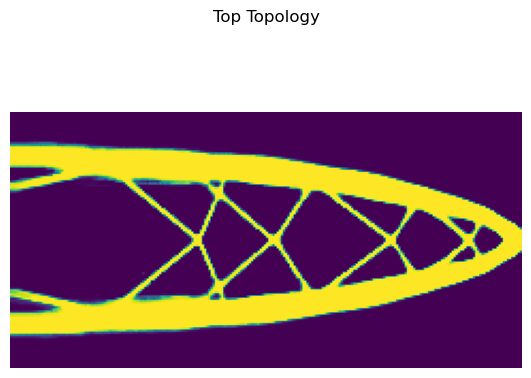

In [ ]:
fig = plt.figure()
plt.suptitle("Top Topology")

plt.axis('off') 
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=1, 
                    hspace=0.5)

# for i in range(1,n+1):
#     for j in range(1,n+1):
        # count +=1 
        # fig.add_subplot(n, n, count) 


plt.imshow(top_topologies.reshape(120,240))
# plt.title("Idx:"+ str(idx)+ " || BLF: " + str(top_blfs[idx])) 
a=plt.gca()
a.title.set_size(10)

# np.random.seed(seed=None)
# plt.savefig("Plots/Example_Plots_of_inputs")

In [ ]:
# blf_flatten = blf_array_reconstructed.flatten()
# good = np.array(structure_array)[blf_flatten > 10]
# n_good = np.shape(good)[0]
# print("There are " + str(np.shape(good)[0]) + " high performance structures")

# fig, axes = plt.subplots(n_good,1,figsize=(35, 70))
# fig.subplots_adjust(hspace=0.05, wspace=2)
# count = 0
# for i in range(n_good):
#     ims = good[i]
#     axes[i].imshow(ims.reshape(120,240))
#     axes[i].text(10,20,'{0:.3f}'.format(blf_flatten[blf_flatten >8][i]))
#     axes[i].axis("off")
#     count += 1
# # plt.savefig("Plots/Plots_topology_GaussSpace")
# plt.show()

In [ ]:
# np.savetxt( "1204blf_latent_arrays" +'.csv', blf_array_reconstructed, delimiter=',')
# np.savetxt( "1204blf_matlab_arrays" +'.csv', blf_array_matlab, delimiter=',')


In [ ]:
# fig2, ax2 = plt.subplots(1, 1, figsize=(10, 10))
# ax2.axis('equal')
# ax2.plot(np.linspace(0,20,20), np.linspace(0,20,20), c = 'r')
# ax2.scatter(blf_array_matlab.flatten(), blf_array_reconstructed.flatten())
# plt.xlabel("MATLAB")
# plt.ylabel("Reconstructed")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# # Training data
# ax[0].set_title(label="Encoding of Topology BLF from the latent space")

# training_bbox = np.min(Z, axis=0), np.max(Z, axis=0)

# scatter1 = ax[0].scatter(
#     Z[:, 0],
#     Z[:, 1],
#     c= blf_array_reconstructed,
#     alpha=0.2,
#     cmap="plasma",
#     label="Training",
# )
# plt.colorbar(scatter1)

# # # MATLAB calc data.

# ax[1].set_title(label="Encoding of Topology BLF calc from Matlab")


# scatter2 = ax[1].scatter(
#     Z[:, 0],
#     Z[:, 1],
#     c=blf_array_matlab-blf_array_reconstructed,
#     alpha=0.5,
#     marker="+",
#     cmap="plasma",
# )
# plt.colorbar(scatter2)

# # ax[1].legend(*scatter.legend_elements(), title="blf", bbox_to_anchor=(1, 0.5))

# # adjust such that both subplots have same bounds
# ax[0].set_xlim(
#     training_bbox[0][0]-0.5,
#     training_bbox[1][0]+0.5,
# )

# ax[0].set_ylim(
#     training_bbox[0][1]-0.5,
#     training_bbox[1][1]+0.5
# )

# ax[1].set_xlim(
#     training_bbox[0][0]-0.5,
#     training_bbox[1][0]+0.5,
# )

# ax[1].set_ylim(
#     training_bbox[0][1]-0.5,
#     training_bbox[1][1]+0.5
# )


In [ ]:
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
# import numpy as np

# # np.random.seed(1234)
# fig = plt.figure()
# ax1 = fig.add_subplot(111, projection='3d')
# # A = np.random.randint(5, size=(25, 10))
# A = blf_array

# x = np.array([[i] * n for i in range(n)]).ravel() # x coordinates of each bar
# y = np.array([i for i in range(n)] * n) # y coordinates of each bar